In [59]:
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from skimage.transform import rescale
from skimage.color import rgb2gray, gray2rgb
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split
from torchvision import transforms, utils
import random
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import time
import cv2
from skimage import img_as_ubyte

In [4]:
plt.ion()

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
path='images/test_256/'
items = os.listdir(path)
files = np.array([item for item in items if os.path.isfile(os.path.join(path, item)) and io.imread(os.path.join(path,item)).shape==(256,256,3)])
d={'image':files}
dataframe=pd.DataFrame(data=d)
del d
del files
del items
#ind=[i for i in range(len(files)) if io.imread(os.path.join(path,'{}'.format(dataframe.loc[i]['image']))).shape!=(256,256,3)]
#dataframe.drop(ind,axis=0,inplace=True)
#dataframe=dataframe.reset_index(drop=True)
dataframe.count()

image    364138
dtype: int64

In [8]:
dataframe.to_csv('list.csv',index_label=False)

In [9]:
def showimage(image):
    plt.imshow(image)

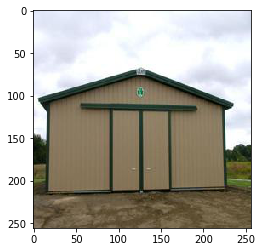

In [10]:
img_num=1035
img_path=os.path.join('images/test_256/','{}'.format(dataframe.loc[img_num]['image']))
showimage(io.imread(img_path))

In [11]:
def image_transform(image):
    #Construct the mask
    mask=np.zeros((128,128,3))
    mask[48:80,48:80]=1
    
    image=image/np.amax(image) #All entries of image between 0 and 1
    image=rescale(image,0.5,anti_aliasing=True,multichannel=True) # Rescale image to 128*128*3
    if (image.shape==mask.shape):
        i=np.multiply(image,np.ones(mask.shape)-mask) #Find the unmasked portion
        mu=np.mean(i) #Calculate the mean over unmasked portion
        im=mu*mask+i #Set the outer pixel of channel to mean value calculated above
        gray_img = rgb2gray(mask) 
        ip=np.dstack((im,gray_img)) #Stack final image with the mask
        if (image is not None and ip is not None and mask is not None):
            return (image,ip,mask)

In [12]:
class PlacesDataset(Dataset):
    def __init__(self,df,img_dir,transform=None):
        self.df=df
        self.img_dir=img_dir
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img_path=os.path.join(self.img_dir,'{}'.format(self.df.loc[idx]['image']))
        if(img_path is not None):
            image=io.imread(img_path)
            if (image is not None):
                image,tr_image,mask=image_transform(image)
                sample={'orig_image':image,'new_image':tr_image,'mask':mask}
                if self.transform:
                    sample['orig_image']=self.transform(sample['orig_image'])
                    sample['new_image']=self.transform(sample['new_image'])
                    sample['mask']=self.transform(sample['mask'])
        
                return sample

In [13]:
dataset=PlacesDataset(dataframe,img_dir='images/test_256/',transform=transforms.Compose([transforms.ToTensor()]))

In [14]:
for i in range(1034,1036):
    sample=dataset[i]
    print (i,sample['orig_image'].size(),sample['new_image'].size(),sample['mask'].size())

1034 torch.Size([3, 128, 128]) torch.Size([4, 128, 128]) torch.Size([3, 128, 128])
1035 torch.Size([3, 128, 128]) torch.Size([4, 128, 128]) torch.Size([3, 128, 128])


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

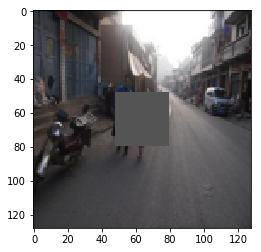

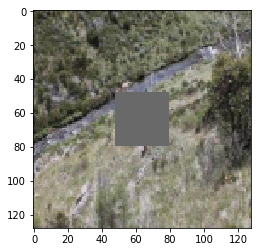

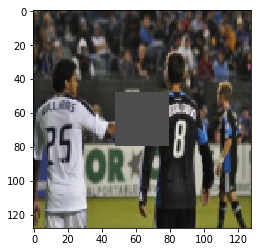

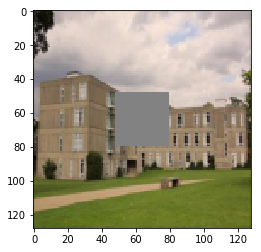

In [16]:
for i in range(1121,1125):
    sample=dataset[i]
    imshow(sample['new_image'][0:3,:,:])
    plt.show()

In [21]:
random.seed(0)
num_train=len(dataset)
indices=list(range(num_train))
test_idx = indices[-210:]
train_idx = list(set(indices) - set(test_idx))
test_data = Subset(dataset,test_idx)
train_data=Subset(dataset,train_idx)
validation_data,test_data=random_split(test_data,(20,190))
a=len(train_data)-90000
train_phase_1,train_phase_2,train_phase_3=random_split(train_data,(70000,20000,a))

In [22]:
train_loader_p1 = torch.utils.data.DataLoader(train_phase_1,batch_size=100)
train_loader_p2 = torch.utils.data.DataLoader(train_phase_2,batch_size=100)
train_loader_p3 = torch.utils.data.DataLoader(train_phase_3,batch_size=100)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)

In [58]:
len(train_loader_p3)

2740

In [66]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1=nn.Conv2d(in_channels=4,out_channels=64,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm1=nn.BatchNorm2d(num_features=64)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=2,dilation=1,stride=2,padding=0)
        self.norm2=nn.BatchNorm2d(num_features=128)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=2,dilation=1,stride=2,padding=0)
        self.norm3=nn.BatchNorm2d(num_features=256)
        self.conv4=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm4=nn.BatchNorm2d(num_features=256)
        self.conv5=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=2,stride=1,padding=2)
        self.norm5=nn.BatchNorm2d(num_features=256)
        self.conv6=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=4,stride=1,padding=4)
        self.norm6=nn.BatchNorm2d(num_features=256)
        self.conv7=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=4,stride=1,padding=4)
        self.norm7=nn.BatchNorm2d(num_features=256)
        #self.conv8=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=8,stride=1,padding=8)
        #self.norm8=nn.BatchNorm2d(num_features=256)
        #self.conv9=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=16,stride=1,padding=16)
        #self.norm9=nn.BatchNorm2d(num_features=256)
        self.conv8=nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,dilation=1,stride=2,padding=1)
        self.norm8=nn.BatchNorm2d(num_features=128)
        self.conv9=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm9=nn.BatchNorm2d(num_features=128)
        self.conv10=nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,dilation=1,stride=2,padding=1)
        self.norm10=nn.BatchNorm2d(num_features=64)
        self.conv11=nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3,dilation=1,stride=1,padding=1)
        self.relu=nn.ReLU()
        self.sigm=nn.Sigmoid()
        
    def forward(self,x):
        x=x.type(torch.cuda.FloatTensor)
        out=self.conv1(x)
        out=self.relu(out)
        out=self.norm1(out)
        #print (out.size())
        out=self.conv2(out)
        out=self.relu(out)
        out=self.norm2(out)
        #print (out.size())
        out=self.conv3(out)
        out=self.relu(out)
        out=self.norm3(out)
        #print (out.size())
        out=self.conv4(out)
        out=self.relu(out)
        out=self.norm4(out)
        #print (out.size())
        out=self.conv5(out)
        out=self.relu(out)
        out=self.norm5(out)
        #print (out.size())
        out=self.conv6(out)
        out=self.relu(out)
        out=self.norm6(out)
        #print (out.size())
        out=self.conv7(out)
        out=self.relu(out)
        out=self.norm7(out)
        #print (out.size())
        #out=self.conv8(out)
        #out=self.relu(out)
        #out=self.norm8(out)
        #print (out.size())
        #out=self.conv9(out)
        #out=self.relu(out)
        #out=self.norm9(out)
        #print (out.size())
        out=self.conv8(out)
        out=self.relu(out)
        out=self.norm8(out)
        #print (out.size())
        out=self.conv9(out)
        out=self.relu(out)
        out=self.norm9(out)
        out=self.conv10(out)
        out=self.relu(out)
        out=self.norm10(out)
        
        out=self.conv11(out)
        out=self.sigm(out)
        #print (out.size())
        
        return out

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1g=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,dilation=1,stride=2)
        self.norm1g=nn.BatchNorm2d(num_features=32)
        self.conv2g=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,dilation=1,stride=2)
        self.norm2g=nn.BatchNorm2d(num_features=64)
        self.conv3g=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,dilation=1,stride=2)
        self.norm3g=nn.BatchNorm2d(num_features=128)
        self.conv4g=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,dilation=1,stride=2)
        self.norm4g=nn.BatchNorm2d(num_features=256)
        self.conv5g=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=5,dilation=1,stride=2)
        
        self.conv1l=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,dilation=1,stride=2)
        self.norm1l=nn.BatchNorm2d(num_features=32)
        self.conv2l=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,dilation=1,stride=2)
        self.norm2l=nn.BatchNorm2d(num_features=64)
        self.conv3l=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,dilation=1,stride=2)
        self.norm3l=nn.BatchNorm2d(num_features=128)
        self.conv4l=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,dilation=1,stride=2)
        
        self.fc=nn.Linear(768,1)
        self.relu=nn.ReLU()
        self.sigm=nn.Sigmoid()
        
    def forward(self,x):
        x=x.type(torch.cuda.FloatTensor)
        out_g=self.conv1g(x)
        out_g=self.relu(out_g)
        out_g=self.norm1g(out_g)
        #print (out_g.size())
        out_g=self.conv2g(out_g)
        out_g=self.relu(out_g)
        out_g=self.norm2g(out_g)
        #print (out_g.size())
        out_g=self.conv3g(out_g)
        out_g=self.relu(out_g)
        out_g=self.norm3g(out_g)
        #print (out_g.size())
        out_g=self.conv4g(out_g)
        out_g=self.relu(out_g)
        out_g=self.norm4g(out_g)
        #print (out_g.size())
        out_g=self.conv5g(out_g)
        out_g=self.relu(out_g)
        #print (out_g.size())
        out_g=out_g.view(-1,512)
        
        
        y=x[:,:,32:96,32:96]
        out_l=self.conv1l(y)
        out_l=self.relu(out_l)
        out_l=self.norm1l(out_l)
        #print (out_l.size())
        out_l=self.conv2l(out_l)
        out_l=self.relu(out_l)
        out_l=self.norm2l(out_l)
        #print (out_l.size())
        out_l=self.conv3l(out_l)
        out_l=self.relu(out_l)
        out_l=self.norm3l(out_l)
        #print (out_l.size())
        out_l=self.conv4l(out_l)
        out_l=self.relu(out_l)
        #print (out_l.size())
        out_l=out_l.view(-1,256)
        
        out=torch.cat((out_g,out_l),1)
        out=self.relu(out)
        out=self.fc(out)
        out=self.sigm(out)
        
        return out

In [45]:
def train_generator(model,train_loader,g_optimizer,g_criterion,epoch,num_epochs,epochs,rl_g):
    running_loss=0
    generator.train()
    for i,(sample) in enumerate(train_loader):
        i_p=Variable(sample['new_image']).to(device)
        i_n=Variable(sample['orig_image']).to(device)
        mask=Variable(sample['mask']).to(device)
        mask=mask.type(torch.cuda.FloatTensor)
        i_n=i_n.type(torch.cuda.FloatTensor)
        g_optimizer.zero_grad()
        i_o=generator(i_p)
        #print (i_o.size(),mask.size())
        loss=g_criterion(torch.mul(i_o,mask),torch.mul(i_n,mask))
        loss.backward()
        g_optimizer.step()
        running_loss+=loss.item()
        rl_g.append(loss.item())
        if((i+1)%140==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss: {}'.format(epoch+1-epochs, num_epochs, int((i+1)/140),5 , round(running_loss/140,4)))
            running_loss=0

In [46]:
def evaluate(generator,validation_loader,g_criterion,epoch,num_epochs,epochs):
    running_loss=0
    generator.eval()
    with torch.no_grad():
        for i,(sample) in enumerate(validation_loader):
            i_p=Variable(sample['new_image']).to(device)
            i_n=Variable(sample['orig_image']).to(device)
            mask=Variable(sample['mask']).to(device)
            mask=mask.type(torch.cuda.FloatTensor)
            i_n=i_n.type(torch.cuda.FloatTensor)
            i_o=generator(i_p)
            i_p=i_p[:,0:3,:,:]
            loss=g_criterion(torch.mul(i_o,mask),torch.mul(i_n,mask))
            running_loss+=loss.item()
    
    print ('Epoch: [{}/{}] | Validation Loss: {}'.format(epoch+1-epochs, num_epochs,running_loss/20))

In [47]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [48]:
def train_discriminator(model,train_loader,d_optimizer,d_criterion,epoch,num_epochs,epochs,rl_d_fake,rl_d_real):
    running_loss_real=0
    running_loss_fake=0
    discriminator.train()
    for i,(sample) in enumerate(train_loader):
        i_p=Variable(sample['new_image']).to(device)
        i_n=Variable(sample['orig_image']).to(device)
        d_optimizer.zero_grad()
        i_o=generator(i_p).detach()
        d_i_o=discriminator(i_o)
        d_i_n=discriminator(i_n)
        
        loss_real=d_criterion(d_i_n,ones_target(100).to(device))
        loss_real.backward()
        rl_d_real.append(loss_real.item())
        
        loss_fake=d_criterion(d_i_o,zeros_target(100).to(device))
        loss_fake.backward()
        rl_d_fake.append(loss_fake.item())
        
        d_optimizer.step()
        
        running_loss_real+=loss_real.item()
        running_loss_fake+=loss_fake.item()
        if((i+1)%40==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss_Real: {} | Loss_fake: {}'.format(epoch+1-epochs, num_epochs, int((i+1)/40),2 , round(running_loss_real/40,4), round(running_loss_fake/40,4)))
            running_loss_real=0
            running_loss_fake=0

In [49]:
def train_both(model_gen,model_dis,train_loader,d_criterion,g_criterion,d_optimizer,g_optimizer,epoch,num_epochs,epochs,alpha,rl_dis_real,rl_dis_fake,rl_gen):
    running_loss_d_real=0
    running_loss_d_fake=0
    running_loss_g=0
    generator.train()
    discriminator.train()
    for i,(sample) in enumerate(train_loader):
        i_p=Variable(sample['new_image']).to(device)
        i_n=Variable(sample['orig_image']).to(device)
        i_n=i_n.type(torch.cuda.FloatTensor)
        mask=Variable(sample['mask']).to(device)
        mask=mask.type(torch.cuda.FloatTensor)
        d_optimizer.zero_grad()
        i_o=generator(i_p).detach()
        
        #Discriminator Training
        
        d_i_o=discriminator(i_o)
        d_i_n=discriminator(i_n)
        loss_real=d_criterion(d_i_n,ones_target(100).to(device))
        loss_real.backward()
        rl_d_real.append(loss_real.item())
        
        loss_fake=d_criterion(d_i_o,zeros_target(100).to(device))
        loss_fake.backward()
        rl_d_fake.append(loss_fake.item())
        
        d_optimizer.step()
        
        running_loss_d_real+=loss_real.item()
        running_loss_d_fake+=loss_fake.item()
        
        #Generator training
        
        g_optimizer.zero_grad()
        i_o=generator(i_p)
        d_i_o=discriminator(i_o).detach()
        #loss_g=g_criterion(torch.mul(i_o,mask),torch.mul(i_n,mask))-torch.sum(torch.mul(torch.log(d_i_o),alpha))
        loss_g=g_criterion(torch.mul(i_o,mask),torch.mul(i_n,mask)) + alpha*d_criterion(d_i_o,zeros_target(100).to(device))
        loss_g.backward()
        g_optimizer.step()
        running_loss_g+=loss_g.item()
        rl_gen.append(loss_g)
        if((i+1)%269==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Gen_Loss: {} | Dis_Loss_real: {} | Dis_Loss_fake: {}'.format(epoch+1-epochs, num_epochs, int((i+1)/269),8 , round(running_loss_g/269,4), round(running_loss_d_real/269,4), round(running_loss_d_fake/269,4)))
            running_loss_g=0
            running_loss_d=0

In [67]:
generator = Generator()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
generator=generator.to(device)
g_criterion = nn.MSELoss()
g_optimizer = torch.optim.Adam(generator.parameters())

cuda:0


In [51]:
discriminator=Discriminator()
discriminator=discriminator.to(device)
d_criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters())

In [68]:
#num_epochs_gen=5
checkpoint = torch.load('GAN/gen_model_1.pth')
generator.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epochs_gen = checkpoint['epoch']
#rl_g = checkpoint['loss']

generator.eval()


Generator(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (norm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  (norm6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [57]:
#num_epochs_gen=5
#epochs_gen=0
#rl_g=[]
for epoch_gen in range(epochs_gen,num_epochs_gen+epochs_gen):
    train_generator(generator,train_loader_p1,g_optimizer,g_criterion,epoch_gen,num_epochs_gen,epochs_gen,rl_g)
    print ('%---Saving the model---%')
    torch.save({
            'epoch': int(epoch_gen)+1,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': rl_g,
            },'Generator/model_{}.pth'.format(epoch_gen+1))


Epoch: [1/5] | Step: [1/5] | Loss: 0.0015
Epoch: [1/5] | Step: [2/5] | Loss: 0.0015
Epoch: [1/5] | Step: [3/5] | Loss: 0.0015
Epoch: [1/5] | Step: [4/5] | Loss: 0.0015
Epoch: [1/5] | Step: [5/5] | Loss: 0.0015
%---Saving the model---%
Epoch: [2/5] | Step: [1/5] | Loss: 0.0015
Epoch: [2/5] | Step: [2/5] | Loss: 0.0015
Epoch: [2/5] | Step: [3/5] | Loss: 0.0015
Epoch: [2/5] | Step: [4/5] | Loss: 0.0015
Epoch: [2/5] | Step: [5/5] | Loss: 0.0015
%---Saving the model---%
Epoch: [3/5] | Step: [1/5] | Loss: 0.0015
Epoch: [3/5] | Step: [2/5] | Loss: 0.0015
Epoch: [3/5] | Step: [3/5] | Loss: 0.0015
Epoch: [3/5] | Step: [4/5] | Loss: 0.0015
Epoch: [3/5] | Step: [5/5] | Loss: 0.0015
%---Saving the model---%
Epoch: [4/5] | Step: [1/5] | Loss: 0.0015
Epoch: [4/5] | Step: [2/5] | Loss: 0.0015
Epoch: [4/5] | Step: [3/5] | Loss: 0.0015
Epoch: [4/5] | Step: [4/5] | Loss: 0.0015
Epoch: [4/5] | Step: [5/5] | Loss: 0.0015
%---Saving the model---%
Epoch: [5/5] | Step: [1/5] | Loss: 0.0015
Epoch: [5/5] | Ste

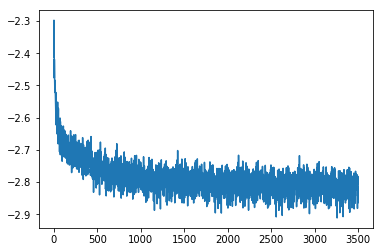

In [54]:
plt.plot(range(len(rl_g)),np.log10(rl_g))
plt.show()

In [69]:
#num_epochs_dis=10
checkpoint = torch.load('GAN/dis_model_1.pth')
discriminator.load_state_dict(checkpoint['model_state_dict'])
d_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epochs_dis = checkpoint['epoch']
#rl_d = checkpoint['loss']

discriminator.eval()


Discriminator(
  (conv1g): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
  (norm1g): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2g): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (norm2g): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3g): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
  (norm3g): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4g): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
  (norm4g): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5g): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2))
  (conv1l): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
  (norm1l): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2l): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (norm2l): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [44]:
num_epochs_dis=10
epochs_dis=0
rl_d_fake=[]
rl_d_real=[]
for epoch_dis in range(epochs_dis,num_epochs_dis+epochs_dis):
    train_discriminator(discriminator,train_loader_p2,d_optimizer,d_criterion,epoch_dis,num_epochs_dis,epochs_dis,rl_d_fake,rl_d_real)
    print ('%---Saving the model---%')
    torch.save({
            'epoch': int(epoch_dis+1),
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'Fake loss': rl_d_fake,
            'Real loss': rl_d_real,
            },'Discriminator/model_{}.pth'.format(epoch_dis+1))

Epoch: [1/10] | Step: [1/2] | Loss_Real: 0.075 | Loss_fake: 0.0384
Epoch: [1/10] | Step: [2/2] | Loss_Real: 0.0008 | Loss_fake: 0.0004
Epoch: [1/10] | Step: [3/2] | Loss_Real: 0.0002 | Loss_fake: 0.0002
Epoch: [1/10] | Step: [4/2] | Loss_Real: 0.0001 | Loss_fake: 0.0
Epoch: [1/10] | Step: [5/2] | Loss_Real: 0.0 | Loss_fake: 0.0
%---Saving the model---%
Epoch: [2/10] | Step: [1/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [2/10] | Step: [2/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [2/10] | Step: [3/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [2/10] | Step: [4/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [2/10] | Step: [5/2] | Loss_Real: 0.0 | Loss_fake: 0.0
%---Saving the model---%
Epoch: [3/10] | Step: [1/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [3/10] | Step: [2/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [3/10] | Step: [3/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [3/10] | Step: [4/2] | Loss_Real: 0.0 | Loss_fake: 0.0
Epoch: [3/10] | Step: [5/2] | Loss_Real: 0.0 | Loss_fake: 0.0


KeyboardInterrupt: 

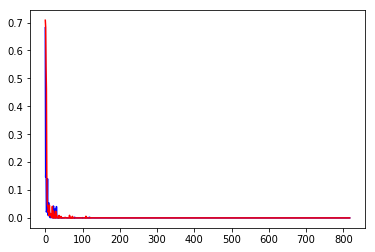

In [45]:
plt.plot(range(len(rl_d_fake)),rl_d_fake,color='blue')
plt.plot(range(len(rl_d_real)),rl_d_real,color='red')
plt.show()

In [48]:
epochs=0
num_epochs=5
rl_dis_real=[]
rl_dis_fake=[]
rl_gen=[]
for epoch in range(epochs,num_epochs+epochs):
    train_both(generator,discriminator,train_loader_p3,d_criterion,g_criterion,d_optimizer,g_optimizer,epoch,num_epochs,epochs,0.0004,rl_dis_real,rl_dis_fake,rl_gen)
    evaluate(generator,validation_loader,g_criterion,epoch,num_epochs,epochs)
    print ('%---Saving the model---%')
    torch.save({
            'epoch': int(epoch+1),
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss_real': rl_dis_real,
            'loss_fake': rl_dis_real,
            },'GAN/dis_model_{}.pth'.format(epoch+1))
    torch.save({
            'epoch': int(epoch+1),
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': rl_gen,
            },'GAN/gen_model_{}.pth'.format(epoch+1))
    

Epoch: [1/5] | Step: [1/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [2/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [3/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [4/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [5/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [6/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [7/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [8/8] | Gen_Loss: 0.0014 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [9/8] | Gen_Loss: 0.0014 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Step: [10/8] | Gen_Loss: 0.0015 | Dis_Loss_real: 0.0 | Dis_Loss_fake: 0.0
Epoch: [1/5] | Validation Loss: 0.0023681477818172426
%---Saving the model---%


KeyboardInterrupt: 

In [88]:
def evaluate_2(generator,validation_loader,g_criterion,epoch,num_epochs,epochs):
    running_loss=0
    generator.eval()
    with torch.no_grad():
        for i,(sample) in enumerate(validation_loader):
            i_p=Variable(sample['new_image']).to(device)
            i_n=Variable(sample['orig_image']).to(device)
            mask=Variable(sample['mask']).to(device)
            mask=mask.type(torch.cuda.FloatTensor)
            i_n=i_n.type(torch.cuda.FloatTensor)
            i_o=generator(i_p)
            #print (i_p.size())
            i_p=i_p[:,0:3,:,:]
            i_p=i_p.type(torch.cuda.FloatTensor)
            src=torch.mul(i_o,mask)[0].cpu().numpy()
            src=np.transpose(src, (1, 2, 0))
            src[0:48,0:48,:]=0
            src[80:,80:,:]=0
            src=src[48:80,48:80,:]
            #src=255*src
            #cv2.imwrite('images/val/src.jpg',src)
            #src=cv2.imread('images/val/src.jpg')
            dst=torch.mul(i_n,-1*torch.add(mask,-1))[0].cpu().numpy()
            dst=np.transpose(dst, (1, 2, 0))
            #cv2.imwrite('images/val/dst.jpg',dst)
            #dst=cv2.imread('images/val/dst.jpg')
            
            mask=255*np.ones(src.shape, src.dtype)
            #dst=255*dst
            #print(src.shape,dst.shape,center,mask.shape)
            src = img_as_ubyte(src)
            dst = img_as_ubyte(dst)
            dst=dst[:,:,20:98]
            width, height, channels = dst.shape
            center = (int(height/2), int(width/2))
            img = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)
            #img=src+dst
            #img=img[0].cpu()
            #print(img.size())
            showimage(img)
            plt.show()
            #loss=g_criterion(torch.mul(i_o,mask),torch.mul(i_n,mask))
            #running_loss+=loss.item()
    
    #print ('Epoch: [{}/{}] | Validation Loss: {}'.format(epoch+1-epochs, num_epochs,running_loss/21))

In [89]:
evaluate_2(generator,validation_loader,g_criterion,epoch=0,num_epochs=0,epochs=0)

error: OpenCV(3.4.5) /io/opencv/modules/imgproc/src/shapedescr.cpp:741: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'pointSetBoundingRect'
